# Tutorial: Extracting the Place of Birth of American Presidents from their Wikipedia HTML Pages

If you already have the database pob_presidents in your postgresql, please uncomment the first line to drop and create it.

In [1]:
! dropdb --if-exists pob_presidents
! createdb pob_presidents

# Introduction

We will walk through the process of using `Fonduer` to extract relations from [**richly formatted** data](https://hazyresearch.github.io/snorkel/blog/fonduer.html), where information is conveyed via combinations of textual, structural and tabular, and visual expressions, as seen in webpages, business reports, product specifications, and scientific literature.

In this tutorial, we use `Fonduer` to identify the place of birth of presidents and vice presidents from their wikipedia articles. The HTML files are generated from Wikipedia's markup language Wikitext via [wtf_wikipedia](https://github.com/spencermountain/wtf_wikipedia).

The tutorial is broken into several parts, each covering a phase of the `Fonduer` pipeline (as outlined in the [paper](https://arxiv.org/abs/1703.05028)), and the iterative KBC process:

1. KBC Initialization
2. Candidate Generation and Multimodal Featurization
3. Probabilistic Relation Classification
4. Error Analysis and Iterative KBC

In addition, we show how users can iteratively improve labeling functions to improve relation extraction quality.

# Phase 1: KBC Initialization

In this first phase of `Fonduer`'s pipeline, `Fonduer` uses a user-specified _schema_ to initialize a relational database where the output KB will be stored. Furthermore, `Fonduer` iterates over its input _corpus_ and transforms each document into a unified data model, which captures the variability and multimodality of richly formatted data. This unified data model then servers as an intermediate representation used in the rest of the phases.

This preprocessed data is saved to a database. The connection string to the database is provided to the `Meta` object, which will initialize a PostgreSQL database for parallel execution.

We initialize several variables for convenience that define what the database should be called and what level of parallelization the `Fonduer` pipeline will be run with.

Before you continue, please make sure that you have PostgreSQL installed and have created a new database named `pob_presidents`.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import logging

# Configure logging for Fonduer
logging.basicConfig(stream=sys.stdout, format='[%(levelname)s] %(name)s - %(message)s')
log = logging.getLogger('fonduer')
log.setLevel(logging.INFO)

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "pob_presidents"
conn_string = 'postgres://localhost:5432/' + ATTRIBUTE

## 1.1 Parsing and Transforming the Input Documents into Unified Data Models

We first initialize a `Meta` object, which manages the connection to the database automatically, and enables us to save intermediate results.

In [3]:
from fonduer import Meta

session = Meta.init(conn_string).Session()

[INFO] fonduer.meta - Connecting user:None to localhost:5432/pob_presidents
[INFO] fonduer.meta - Initializing the storage schema


Next, we load the corpus of wikpedia articles and transform them into the unified data model. Each article is represented by an HTML file. The HTML file is parsed to create a robust unified data model with textual, structural, and tabular modality information. Note that since each document is independent of each other, we can parse the documents in parallel. We depend on PostgreSQL for this functionality.

### Configuring an `HTMLDocPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLDocPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the maximum number of documents to parse.

**Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.**

In [4]:
from fonduer.parser.preprocessors import HTMLDocPreprocessor
from fonduer.parser import Parser

docs_path = 'data/presidents/'
doc_preprocessor = HTMLDocPreprocessor(docs_path)

### Configuring a `Parser`
Next, we configure a `Parser`, which serves as our `CorpusParser` for PDF documents. We use [spaCy](https://spacy.io/) as a preprocessing tool to split our documents into sentences and tokens.In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable structural information, as well as lingual information, which uses [spaCy] to provide annotations such as part-of-speech tags and dependency parse structures for these sentences. 
Note that after the progress bar indicates the completion of the parsing process, some more time will pass until all objects have been inserted into the database.

In [5]:
corpus_parser = Parser(session, structural=True, lingual=True)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 1.85 s, sys: 272 ms, total: 2.12 s
Wall time: 6min 35s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many sentences are contained in each document.

In [6]:
from fonduer.parser.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 78
Sentences: 95151


## 1.2 Dividing the Corpus into Test and Train

We'll split the documents 80/10/10 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [7]:
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.7, 0.85)
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint
pprint([x.name for x in train_docs])

['Abraham_Lincoln',
 'Grover_Cleveland',
 'Franklin_D._Roosevelt',
 'Martin_Van_Buren',
 'Charles_W._Fairbanks',
 'Hannibal_Hamlin',
 'Elbridge_Gerry',
 'Gerald_Ford',
 'Andrew_Johnson',
 'Dwight_D._Eisenhower',
 'Charles_G._Dawes',
 'Henry_Wilson',
 'Dan_Quayle',
 'Jimmy_Carter',
 'Daniel_D._Tompkins',
 'Lyndon_B._Johnson',
 'Harry_S._Truman',
 'Charles_Curtis',
 'James_Monroe',
 'Hubert_Humphrey',
 'James_S._Sherman',
 'Henry_A._Wallace',
 'Joe_Biden',
 'George_H._W._Bush',
 'Calvin_Coolidge',
 'John_Adams',
 'Chester_A._Arthur',
 'James_Madison',
 'Andrew_Jackson',
 'George_Washington',
 'Al_Gore',
 'James_K._Polk',
 'James_A._Garfield',
 'Bill_Clinton',
 'George_M._Dallas',
 'Aaron_Burr',
 'James_Buchanan',
 'John_Nance_Garner',
 'Barack_Obama',
 'Herbert_Hoover',
 'John_C._Calhoun',
 'Benjamin_Harrison',
 'George_W._Bush',
 'John_F._Kennedy',
 'Franklin_Pierce',
 'John_C._Breckinridge',
 'George_Clinton',
 'John_Tyler',
 'Garret_Hobart',
 'Levi_P._Morton',
 'John_Quincy_Adams',
 '

# Phase 2: Mention Extraction, Candidate Extraction Multimodal Featurization

Given the unified data model from Phase 1, `Fonduer` extracts relation
candidates based on user-provided **matchers** and **throttlers**. Then,
`Fonduer` leverages the multimodality information captured in the unified data
model to provide multimodal features for each candidate.

## 2.1 Mention Extraction

The first step is to extract **mentions** from our corpus. A `mention` is the
type of object which makes up a `candidate`. For example, if we wanted to
extract pairs of (vice) president names and their corresponding place of birth, the name would be one `mention` while
the place of birth would be another. These `mention`s are then combined to
create `candidates`, where our task is to predict which `candidates` are true
in the associated document.

We first start by defining and naming our two `mention`s:

In [8]:
from fonduer.candidates.models import mention_subclass

Presidentname = mention_subclass("Presidentname")
Placeofbirth = mention_subclass("Placeofbirth")


Next, we write **matchers** to define which spans of text in the corpus are
instances of each entity. Matchers can leverage a variety of information from
regular expressions, to dictionaries, to user-defined functions. Furthermore,
different techniques can be combined to form higher quality matchers. In
general, matchers should seek to be as precise as possible while maintaining
complete recall. More documentation about Matchers can be found on [Read the Docs](https://fonduer.readthedocs.io/en/stable/user/matchers.html).

In our case, we need to write a matcher that defines a string for the name of 
the president and another matcher to define the place of birth

### Writing a simple name matcher

Our name matcher makes use of the fact that the name of the president is 
indicated in the html file name. We define a function that compares a `span` of 
text with the file name to find mentions of the president.
Because we previously converted the document into a unified data model, each
`span` of text has a reference to its source document name, which makes comparison
with the source file name easy:

In [9]:
def mention_span_matches_file_name(mention):
    president_name_string = mention.get_span()
    file_name = mention.sentence.document.name.replace('_',' ')
    if president_name_string == file_name:
        return True
    else:
        return False

We use a `LambdaFunctionMatcher` to wrap this function into a `Fonduer` mention matcher.

In [10]:
from fonduer.candidates.matchers import LambdaFunctionMatcher, Intersect, Union

president_name_matcher = LambdaFunctionMatcher(func=mention_span_matches_file_name)

### Writing an a place of birth matcher

While the place of birth is also a regular string, we rather want to match it based on it's location in the document.
By inspecting the html files, we can find out that each file contains a table with the most important information about the respective president. We observe that there is typically a label in the left column and the corresponding value in the right column.
To capture this information, we define a function that checks whether a `span` is inside a table and its neighboring cells in the same row contain the label 'birth place'.
Furthermore, we observe that birth places are typically split into a fine-grained location, followed by its respective state. As we want to gather more fine-grained information, we specify to extract only the first `spans` of text inside the cell.

In [11]:
from fonduer.utils.data_model_utils import get_row_ngrams

def is_in_birthplace_table_row(mention):
    if not mention.sentence.is_tabular():
        return False
    ngrams = get_row_ngrams(mention, lower=True)
    birth_place_words = set(['birth', 'place'])
    if birth_place_words <= set(ngrams):
        return True
    else:
        return False
    
def birthplace_left_aligned_to_punctuation(mention):
    #Return false, if the cell containing the text candidate does not have any reference
    #to `sentence` objects 
    for sentence in mention.sentence.cell.sentences:
        sentence_parts = sentence.text.split(',')
        for sentence_part in sentence_parts:
            if sentence_part.startswith(mention.get_span()):
                return True
    return False
   # try:
   #     cell_first_sentence_string = mention.sentence.cell.sentences[0].text
   # except IndexError:
   #     return False
   # if mention.get_span() == cell_first_sentence_string or \
   #     cell_first_sentence_string.startswith(mention.get_span()):
   #     return True
    #else:
    #    return False
    
#We only want one granularity of the birth place    
def no_commas_in_birth_place(mention):
    if ',' in mention.get_span():
        return False
    else:
        return True

After defining all functions to capture the properties of a birth place mention, we combine them via an `Intersect` matcher. This matcher will only select a `span`, if all three functions agree.

In [12]:
birth_place_in_labeled_row_matcher = LambdaFunctionMatcher(func=is_in_birthplace_table_row)
birth_place_in_labeled_row_matcher.longest_match_only  = False
birth_place_no_commas_matcher = LambdaFunctionMatcher(func=no_commas_in_birth_place)
birth_place_left_aligned_matcher = LambdaFunctionMatcher(func=birthplace_left_aligned_to_punctuation)

place_of_birth_matcher = Intersect(birth_place_in_labeled_row_matcher, birth_place_no_commas_matcher,
                                birth_place_left_aligned_matcher)

These two matchers define each entity in our relation schema.

### Define a Mention's `MentionSpace`

Next, in order to define the "space" of all mentions that are even considered
from the document, we need to define a `MentionSpace` for each component of the
relation we wish to extract. Fonduer provides a default `MentionSpace` for you
to use, but you can also extend the default `MentionSpace` depending on your
needs.

In the case of names, the `MentionSpace` can be relatively simple: We know that
each name will contain at least two words (first name, last name). Considering
additional middle names, we expect a maximum of four words per name.

Similarly, we expect the place of birth to be a `span` of one to three words.

We use the default `Ngrams` class provided by `fonduer` to define these properties:

In [13]:
from fonduer.candidates import MentionNgrams

presname_ngrams = MentionNgrams(n_max=4, n_min=2)
placeofbirth_ngrams = MentionNgrams(n_max=3)

### Running Mention Extraction 

Next, we create a `MentionExtractor` to extract the mentions from all of
our documents based on the `MentionSpace` and matchers we defined above.

View the API for the MentionExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/candidates.html#fonduer.candidates.MentionExtractor).


In [14]:
from fonduer.candidates import MentionExtractor 

mention_extractor = MentionExtractor(
        session, [Presidentname, Placeofbirth], [presname_ngrams, placeofbirth_ngrams],
        [president_name_matcher, place_of_birth_matcher]
    )

Then, we run the extractor on all of our documents.

In [15]:
from fonduer.candidates.models import Mention

mention_extractor.apply(docs, parallelism=PARALLEL)
num_names = session.query(Presidentname).count()
num_pobs = session.query(Placeofbirth).count()
print("Total Mentions: {} ({} names, {} places of birth)".format(session.query(Mention).count(), num_names, num_pobs))

[INFO] fonduer.candidates.mentions - Clearing table: presidentname
[INFO] fonduer.candidates.mentions - Clearing table: placeofbirth
[INFO] fonduer.utils.udf - Running UDF...



Total Mentions: 1396 (1198 names, 198 places of birth)


## 2.2 Candidate Extraction

Now that we have both defined and extracted the Mentions that can be used to compose Candidates, we are ready to move on to extracting Candidates. Like we did with the Mentions, we first define what each candidate schema looks like. In this example, we create a candidate that is composed of a `Presidentname` and a `Placeofbirth` mention as we defined above. We name this candidate "PresidentnamePlaceofbirth".

In [16]:
from fonduer.candidates.models import candidate_subclass

PresidentnamePlaceofbirth = candidate_subclass("PresidentnamePlaceofbirth", [Presidentname, Placeofbirth])

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Throttlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table. 
NOTE: Currently, we don't use this throttler, as issues with `wtf_wikipedia` lead to the absence of the president name in the table. We therefore skip this stip for now.

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the Mentions that compose each candidate and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the candidate subclass and corresponding throttler to use.

View the API for the CandidateExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/docstrings/user/candidates.html#fonduer.candidates.CandidateExtractor).

In [17]:
from fonduer.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(session, [PresidentnamePlaceofbirth])

Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [18]:
for i, docs in enumerate([train_docs, dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
    print("Number of Candidates in split={}: {}".format(i, session.query(PresidentnamePlaceofbirth).filter(PresidentnamePlaceofbirth.split == i).count()))

train_cands = candidate_extractor.get_candidates(split = 0)
dev_cands = candidate_extractor.get_candidates(split = 1)
test_cands = candidate_extractor.get_candidates(split = 2)

[INFO] fonduer.candidates.candidates - Clearing table presidentname_placeofbirth (split 0)
[INFO] fonduer.utils.udf - Running UDF...



Number of Candidates in split=0: 2590
[INFO] fonduer.candidates.candidates - Clearing table presidentname_placeofbirth (split 1)
[INFO] fonduer.utils.udf - Running UDF...



Number of Candidates in split=1: 564
[INFO] fonduer.candidates.candidates - Clearing table presidentname_placeofbirth (split 2)
[INFO] fonduer.utils.udf - Running UDF...



Number of Candidates in split=2: 327


## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Featurizer
We now annotate the candidates in our training, dev, and test sets with features. The `Featurizer` provided by `Fonduer` allows this to be done in parallel to improve performance.

View the API provided by the `Featurizer` on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/features.html#fonduer.features.Featurizer).

In [19]:
from fonduer.features import Featurizer

featurizer = Featurizer(session, [PresidentnamePlaceofbirth])
%time featurizer.apply(split=0, train=True, parallelism=PARALLEL)
%time F_train = featurizer.get_feature_matrices(train_cands)

[INFO] fonduer.features.featurizer - Clearing Features (split 0)
[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 179 ms, sys: 63.9 ms, total: 243 ms
Wall time: 42.3 s
CPU times: user 3.81 s, sys: 213 ms, total: 4.03 s
Wall time: 5.22 s


In [20]:
print(F_train[0].shape)
%time featurizer.apply(split=1, parallelism=PARALLEL)
%time F_dev = featurizer.get_feature_matrices(dev_cands)
print(F_dev[0].shape)

(2590, 26527)
[INFO] fonduer.features.featurizer - Clearing Features (split 1)
[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 118 ms, sys: 99.9 ms, total: 218 ms
Wall time: 8.85 s
CPU times: user 1.06 s, sys: 33.7 ms, total: 1.09 s
Wall time: 1.36 s
(564, 26527)


In [21]:
%time featurizer.apply(split=2, parallelism=PARALLEL)
%time F_test = featurizer.get_feature_matrices(test_cands)
print(F_test[0].shape)

[INFO] fonduer.features.featurizer - Clearing Features (split 2)
[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 87.3 ms, sys: 88.7 ms, total: 176 ms
Wall time: 8.85 s
CPU times: user 848 ms, sys: 27.6 ms, total: 876 ms
Wall time: 1.03 s
(327, 26527)


At the end of this phase, `Fonduer` has generated the set of candidates and the feature matrix. Note that Phase 1 and 2 are relatively static and typically are only executed once during the KBC process.

# Phase 3: Probabilistic Relation Classification
In this phase, `Fonduer` applies user-defined **labeling functions**, which express various heuristics, patterns, and [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data, to each of the candidates to create a label matrix that is used by our data programming engine.

In the wild, hand-labeled training data is rare and expensive. A common scenario is to have access to tons of unlabeled training data, and have some idea of how to label them programmatically. For example:
* We may have knowledge about typical place constructs, such as combinations of strings with words like 'New','County' or 'City'.
Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which `Fonduer` will help us easily apply.

Using data programming, we can then train machine learning models to learn which features are the most important in classifying candidates.

### Loading Gold Data
For convenience in error analysis and evaluation, we have already annotated the dev and test set for this tutorial, and we'll now load it using an externally-defined helper function. If you're interested in the example implementation details, please see the script we now load:

In [57]:
from wiki_table_utils import load_president_gold_labels

gold_file = 'data/president_tutorial_gold.csv'
load_president_gold_labels(session, PresidentnamePlaceofbirth, gold_file, annotator_name='gold')

Clearing ALL Gold labels
Loading 3481 candidate labels
78 different docs in gold dict



found 1193 positive and 2288 negative labels in wikidata GT
GoldLabels created: 3481


### Creating Labeling Functions

In `Fonduer`, our primary interface through which we provide training signal to
the end extraction model we are training is by writing labeling functions
(**LFs**) (as opposed to hand-labeling massive training sets).

A labeling function isn't anything special. It's just a Python function that
accepts a `Candidate` as the input argument and returns `2` if it says the
Candidate should be marked as true, `1` if it says the `Candidate` should be
marked as false, and `0` if it doesn't know how to vote and abstains. In
practice, many labeling functions are unipolar: it labels only 2s and 0s, or it
labels only 1s and 0s.

Recall that our goal is ultimately to train a high-performance classification
model that predicts which of our Candidates are true mentions of president name to place of birth relations. It turns out that we can do this by writing
potentially low-quality labeling functions!

With `Fonduer`, labeling functions can be written using intuitive patterns
discovered by inspecting the target corpus. A library of data model utilities
which can be used to write labeling functions are outline in [Read the
Docs](http://fonduer.readthedocs.io/en/latest/user/data_model_utils.html). 

We express several of these simple patterns below as a set of labeling functions:

In [166]:
from fonduer.utils.data_model_utils import *
import re

ABSTAIN = 0
FALSE = 1
TRUE = 2

def LF_place_of_birth_has_link(c):
    place = c.placeofbirth
    ancestor_tag_names = get_ancestor_tag_names(place)
    if len(ancestor_tag_names) > 1 and 'a' in ancestor_tag_names:
        return ABSTAIN
    else:
        return FALSE
    
def LF_place_of_birth_is_longest_ordered_span_before_comma(c):
    place = c.placeofbirth
    place_string = place.span.get_span()
    place_sentence_string = place.span.sentence.text
    left_aligned_first_span = place_sentence_string.split(',')[0]
    if place_string == left_aligned_first_span:
           return TRUE
    else:
        return FALSE
    
def LF_place_in_first_sentence_of_cell(c):
    place = c.placeofbirth
    place_sentence = place.span.sentence
    place_cell = place_sentence.cell
    if place_sentence == place_cell.sentences[0]:
        return TRUE
    else:
        return FALSE
    
def LF_place_is_full_sentence(c):
    place = c.placeofbirth
    place_sentence = place.span.sentence
    if place.span.get_span() == place_sentence.text:
        return ABSTAIN
    else:
        return FALSE
    
def LF_place_not_a_US_state(c):
    place = c.placeofbirth
    place_string = place.span.get_span().lower()
    if place_string is None:
        return FALSE
    state_dictionary = set(x.lower() for x in ["Alabama", "Alaska", "Arizona", "Arkansas", "California",
                        "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
                        "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas",
                        "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts",
                        "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
                        "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
                        "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma",
                        "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
                        "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia",
                        "Washington", "West Virginia", "Wisconsin", "Wyoming"])
    if place_string == 'new york city': #exception
        return TRUE
    if place_string in state_dictionary:
        return FALSE
    elif any(x in place_string for x in state_dictionary):
        return FALSE
    else:
        return ABSTAIN
    

Then, we collect all of the labeling function we would like to use into a single list, which is provided as input to the `Labeler`.

In [167]:
president_name_pob_lfs = [
    LF_place_of_birth_has_link,
    LF_place_of_birth_is_longest_ordered_span_before_comma,
    LF_place_not_a_US_state,
    LF_place_in_first_sentence_of_cell,
    LF_place_is_full_sentence
    ]

### Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database. Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.

View the API provided by the `Labeler` on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/supervision.html#fonduer.supervision.Labeler).

In [168]:
from fonduer.supervision import Labeler

labeler = Labeler(session, [PresidentnamePlaceofbirth])
%time labeler.apply(split=0, lfs=[president_name_pob_lfs], train=True, parallelism=PARALLEL)
%time L_train = labeler.get_label_matrices(train_cands)

[INFO] fonduer.supervision.labeler - Clearing Labels (split 0)
[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 246 ms, sys: 100 ms, total: 347 ms
Wall time: 3.08 s
CPU times: user 2.62 s, sys: 106 ms, total: 2.72 s
Wall time: 3.51 s


We can also view statistics about the resulting label matrix.
* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In addition, because we have already loaded the gold labels, we can view the emperical accuracy of these labeling functions when compared to our gold labels using the `analysis` module of [MeTaL](https://github.com/HazyResearch/metal).

In [169]:
from fonduer.supervision import get_gold_labels
L_gold_train = get_gold_labels(session, train_cands, annotator_name='gold')

In [170]:
from metal import analysis

analysis.lf_summary(L_train[0], lf_names=labeler.get_keys(), Y=L_gold_train[0].todense().reshape(-1,).tolist()[0])

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_place_in_first_sentence_of_cell),0,"[1, 2]",1.000000,1.000000,0.622780,2111,479,0.815058
LabelKey (LF_place_is_full_sentence),1,1,0.722008,0.722008,0.423938,1264,606,0.675936
LabelKey (LF_place_not_a_US_state),2,"[1, 2]",0.112355,0.112355,0.080695,282,9,0.969072
LabelKey (LF_place_of_birth_has_link),3,1,0.114672,0.114672,0.042471,287,10,0.966330
LabelKey (LF_place_of_birth_is_longest_ordered_span_before_comma),4,"[1, 2]",1.000000,1.000000,0.622780,2018,572,0.779151


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other. To do so, we use [MeTaL](https://github.com/HazyResearch/metal)'s single-task label model.

In [171]:
from metal.label_model import LabelModel

gen_model = LabelModel(k=2)
%time gen_model.train(L_train[0], n_epochs=500, print_every=100)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 1.198
[E:100]	Train Loss: 0.036
[E:200]	Train Loss: 0.032
[E:300]	Train Loss: 0.031
[E:400]	Train Loss: 0.030
[E:499]	Train Loss: 0.029
Finished Training
CPU times: user 494 ms, sys: 19.2 ms, total: 514 ms
Wall time: 278 ms


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [172]:
train_marginals = gen_model.predict_proba(L_train[0])[:, 1]

We'll look at the distribution of the training marginals:

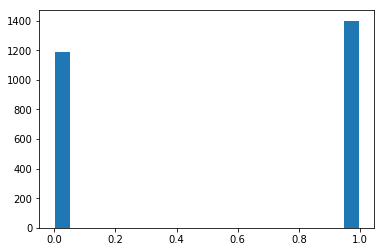

In [173]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [174]:
# gen_model.weights.lf_accuracy
L_train[0].shape

(2590, 5)

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [175]:
labeler.apply(split=1, lfs=[president_name_pob_lfs], parallelism=PARALLEL)
%time L_dev = labeler.get_label_matrices(dev_cands)

[INFO] fonduer.supervision.labeler - Clearing Labels (split 1)
[INFO] fonduer.utils.udf - Running UDF...



CPU times: user 508 ms, sys: 24.4 ms, total: 532 ms
Wall time: 681 ms


In [176]:
L_dev[0].shape

(564, 5)

### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model

Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple--but fairly effective--logistic regression model.

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [ ]:
from fonduer.learning import LogisticRegression

disc_model = LogisticRegression()
%time disc_model.train((train_cands[0], F_train[0]), train_marginals, n_epochs=30, lr=0.001)

[INFO] fonduer.learning.disc_learning - Load defalut parameters for Logistic Regression
[INFO] fonduer.learning.disc_learning - Settings: {'n_epochs': 30, 'lr': 0.001, 'batch_size': 256, 'seed': 1234, 'host_device': 'CPU', 'bias': False, 'input_dim': 26527}
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Training model
[INFO] fonduer.learning.disc_learning - [LogisticRegression] n_train=2590  #epochs=30  batch size=256
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 1 (0.22s)	Average loss=0.617807
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 5 (0.94s)	Average loss=0.377298


### Evaluating on the Test Set
In this final section, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates from earlier:

In [ ]:
import numpy as np
from wiki_table_utils import entity_level_f1

Now, we score using the discriminitive model:

In [ ]:
test_score = disc_model.predictions((test_cands[0], F_test[0]), b=0.6)
true_pred = [test_cands[0][_] for _ in np.nditer(np.where(test_score > 0))]
%time (TP, FP, FN) = entity_level_f1(true_pred, gold_file, test_docs)
print(TP)
print(FP)
print(FN)